## Vehicle Detection

---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

### Loading the labeled data for vehicle and non-vehicle examples to train the classifier

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle


car_images = glob.glob('vehicles/**/*.png')   
noncar_images = glob.glob('non-vehicles/**/*.png')
# Read in cars and notcars data
cars = []
notcars = []
for image in car_images:
    cars.append(image)       
for image in noncar_images:
    notcars.append(image)
print('number of car_images =   ', len(car_images))
print('number of noncar_images =', len(noncar_images))

number of car_images =    8792
number of noncar_images = 8968


### Sample some images and visulize them

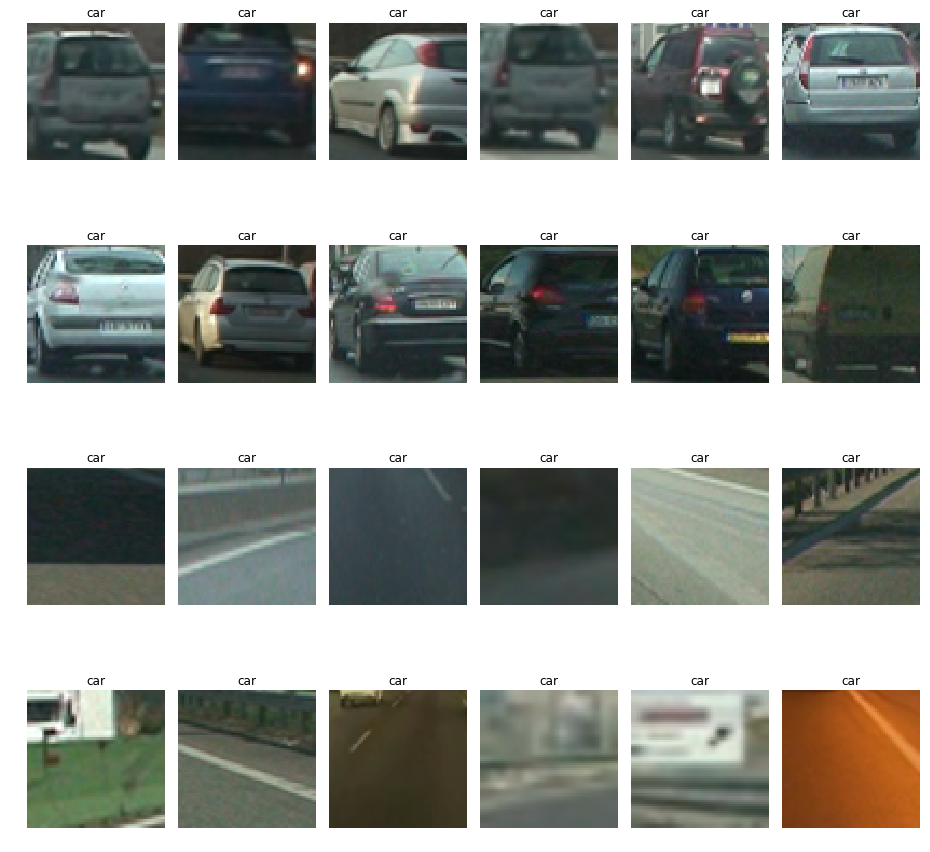

In [2]:
%matplotlib inline

fig, axs = plt.subplots(4, 6, figsize=(16, 16))
fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
axs = axs.ravel()

for i in range(12):
    image = mpimg.imread(car_images[i])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=12)
    axs[i].imshow(image)
for i in range(12, 24):
    image = mpimg.imread(noncar_images[i])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=12)
    axs[i].imshow(image)  
plt.savefig("output_images/sample_car_noncar_images.png") 

### Test get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True) 
parameters:

* img
* orient
* pix_per_cell
* cell_per_block
* vis
* feature_vec

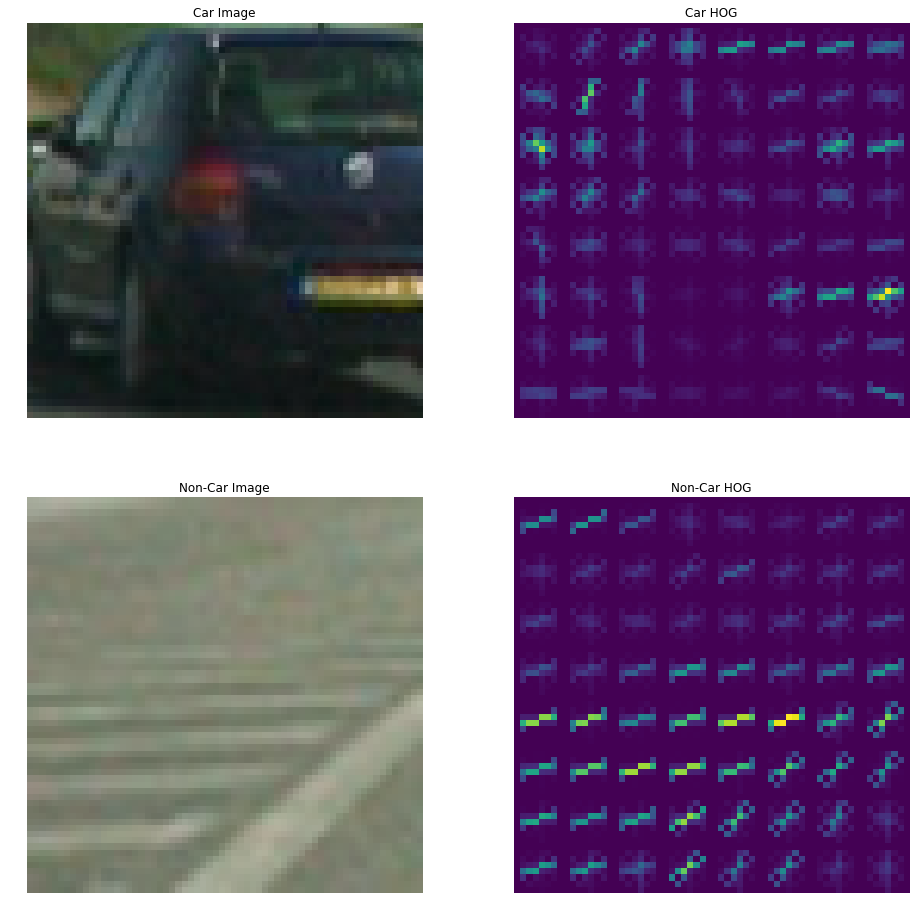

In [39]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog

# Define a function to return HOG features and visualization
# note here that when transform_sqrt=True can cause some issues with LUV color space since the image scale has negative numbers
# The L component has the range [0,100], the U component has the range [-134,220], and the V component has the range [-140,122].

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))

car_image = mpimg.imread(car_images[10])
_, car_hog = get_hog_features(car_image[:,:,2], 11, 8, 2, vis=True, feature_vec=True)
noncar_image = mpimg.imread(noncar_images[10])
_, noncar_hog = get_hog_features(noncar_image[:,:,2], 11, 8, 2, vis=True, feature_vec=True)

ax1.imshow(car_image)
ax1.set_title('Car Image')
ax1.axis('off')
ax2.imshow(car_hog)
ax2.set_title('Car HOG')
ax2.axis('off')
ax3.imshow(noncar_image)
ax3.set_title('Non-Car Image')
ax3.axis('off')
ax4.imshow(noncar_hog)
ax4.set_title('Non-Car HOG')
ax4.axis('off')
plt.savefig("output_images/visual_of_hog.png") 

In [4]:
# Define a function to convert color
def convert_color(image, color_space='RGB'):
    if color_space == 'RGB':
        feature_image = np.copy(image)
    else: 
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    return feature_image    


### Define extract_features(imgs, color_space='RGB', orient=11, pix_per_cell=16, cell_per_block=2, hog_channel="ALL")
paramters:
* imgs
* color_space = 'RGB'
* orient = 11
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = "ALL"

In [5]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', orient=11, pix_per_cell=16, cell_per_block=2, hog_channel="ALL"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'   

        feature_image = convert_color(image, color_space=color_space)
    
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Test extract_features()
paramters:
* imgs
* color_space = 'RGB'
* orient = 11
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = "ALL"

In [6]:
from sklearn.model_selection import train_test_split
# Reduce the sample size because HOG features are slow to compute
sample_size = 8792#500
cars_samples = cars[0:sample_size]
notcars_samples = notcars[0:sample_size]

### Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
case = 0

print(' Case #  ', 'Colorspace', '  Orent ', 'Pixels-Per-Cell', 'Cells-Per-Block', \
      ' HOG-Chanel ', 'Extract-Time', 'Traning-Time', 'Test-Accurace')

# The L component has the range [0,100], the U component has the range [-134,220], 
# and the V component has the range [-140,122].

for colorspace in ('RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'):
    for hog_channel in (0, 1, 2, "ALL"):
# for colorspace in ('LUV','YCrCb'):
#     for hog_channel in (0,"ALL"):
        case += 1
        t=time.time()
     
        car_features = extract_features(cars_samples, color_space=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)     
        notcar_features = extract_features(notcars_samples, color_space=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)    
        t2 = time.time()
        time_to_extract = round(t2-t, 2)
     
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        time_to_train = round(t2-t, 2)
        test_accuracy = round(svc.score(X_test, y_test), 4)

        # Check the prediction time for a single sample
        t=time.time()
        n_predict = 10
        t2 = time.time()
        time_to_predict = round(t2-t, 5)
        print(' {0:3}       {1:5}          {2:1}          {3:2}            {4:1}              {5:3}          {6:.2f}         {7:.2f}         {8:.3f}'
              .format(case, colorspace, orient, pix_per_cell,cell_per_block, hog_channel ,time_to_extract,time_to_train,test_accuracy) )       

        

 Case #   Colorspace   Orent  Pixels-Per-Cell Cells-Per-Block  HOG-Chanel  Extract-Time Traning-Time Test-Accurace
   1       RGB            11          16            2                0          18.84         9.34         0.886
   2       RGB            11          16            2                1          18.05         8.68         0.930
   3       RGB            11          16            2                2          18.18         8.21         0.934
   4       RGB            11          16            2              ALL          41.37         14.30         0.942
   5       HSV            11          16            2                0          19.00         1.33         0.865
   6       HSV            11          16            2                1          19.04         9.47         0.885
   7       HSV            11          16            2                2          18.59         7.99         0.940
   8       HSV            11          16            2              ALL          42.59        

### Training the Classifier: extract features from dataset, split and scale the training and test data, training the classifer with whole dataset (17,760) (Linear SVC)

In [7]:
# First, extra the hog features
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations (9)
pix_per_cell = 16 # HOG pixels per cell (8)
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features ...')
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

43.74 Seconds to extract features ...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [8]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
X_scaler = StandardScaler().fit(X_train)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Trained classifier with {} features '.format(X_train.shape[1]))

# Check the score of the SVC ##############################
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# save the classifier ############################
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block

# pickle.dump(obj, open('svc_pickle.p', 'wb'))
dist_pickle = pickle.dump(dist_pickle,  open("svc_pickle.p", "wb" ) )

print('Trained classifier saved to svc_pickle.p..............')

15.82 Seconds to train SVC...
Trained classifier with 1188 features 
Test Accuracy of SVC =  0.9572
My SVC predicts:      [1. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
For these 10 labels:  [1. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
0.00134 Seconds to predict 10 labels with SVC
Trained classifier saved to svc_pickle.p..............


### Define find_cars() function: find_cars() has verything in this function, it doesn't use extract_features() function

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]

    # apply color conversion if other than 'RGB'        
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
                
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell            
            test_prediction = svc.predict(hog_features.reshape(1, -1))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [10]:
'''
# load a pre-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
# get attributes of our svc object
svc = dist_pickle["svc"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
'''
print('svc            from clf', svc)
print('orient         from clf', orient)
print('pix_per_cell   from clf', pix_per_cell)
print('cell_per_block from clf', cell_per_block)
print('color_space            ', color_space)
print('hog_channel            ', hog_channel)


svc            from clf LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
orient         from clf 11
pix_per_cell   from clf 16
cell_per_block from clf 2
color_space             HSV
hog_channel             ALL


In [11]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


number of boxes  16
ok


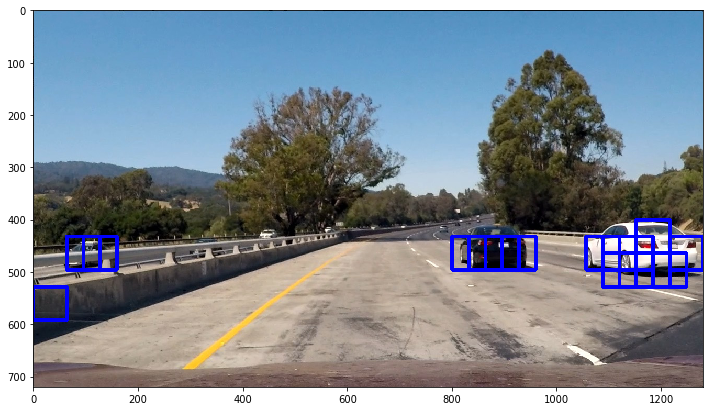

In [12]:
# Test find_cars
img = mpimg.imread('./test_images/test1.jpg')

xstart = 0
xstop = 1280
ystart = 400
ystop =  656
scale =  1.0

car_positions = find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, 
                          svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                          )

print('number of boxes ',len(car_positions))
out_img = draw_boxes(img, car_positions)
plt.figure(figsize=(12,12))
plt.imshow(out_img)
plt.savefig("output_images/test_of_find_cars.png") 
print('ok')

number of boxes  13
ok


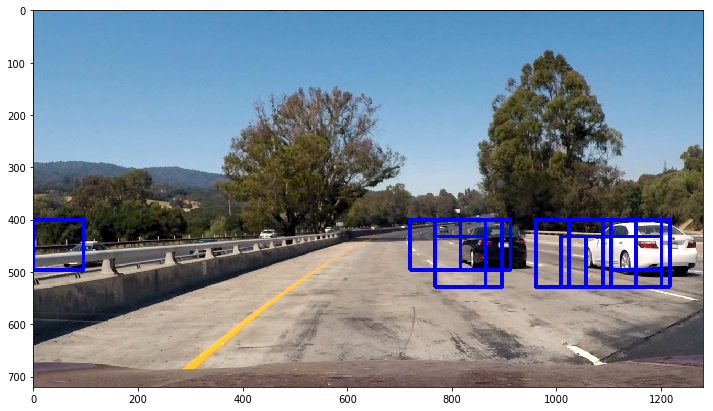

In [43]:
# Test find_cars with different zones and different window size (scale)
img = mpimg.imread('./test_images/test1.jpg')

detected_cars = []

xstart = 64
xstop  = 1280
ystart = 400
ystop = 496
scale = 1.5
detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                               X_scaler, orient, pix_per_cell, cell_per_block)
                    )

ystart = 432
ystop = 528
scale = 1.5
detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc, 
                               X_scaler, orient, pix_per_cell, cell_per_block)
                    )

ystart = 400
ystop =  560
scale =  2.0
detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                               X_scaler, orient, pix_per_cell, cell_per_block)
                    )

ystart = 464
ystop =  660
scale =  3.5
detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                               X_scaler, orient, pix_per_cell, cell_per_block)
                    )
    
car_positions = [i for sublist in detected_cars for i in sublist]
out_img = draw_boxes(img, car_positions)
print('number of boxes ',len(car_positions))
plt.figure(figsize=(12,12))
plt.imshow(out_img)
plt.savefig("output_images/test_with_different_scan_zones.png") 
print('ok')

### Define add_heatmap

ok


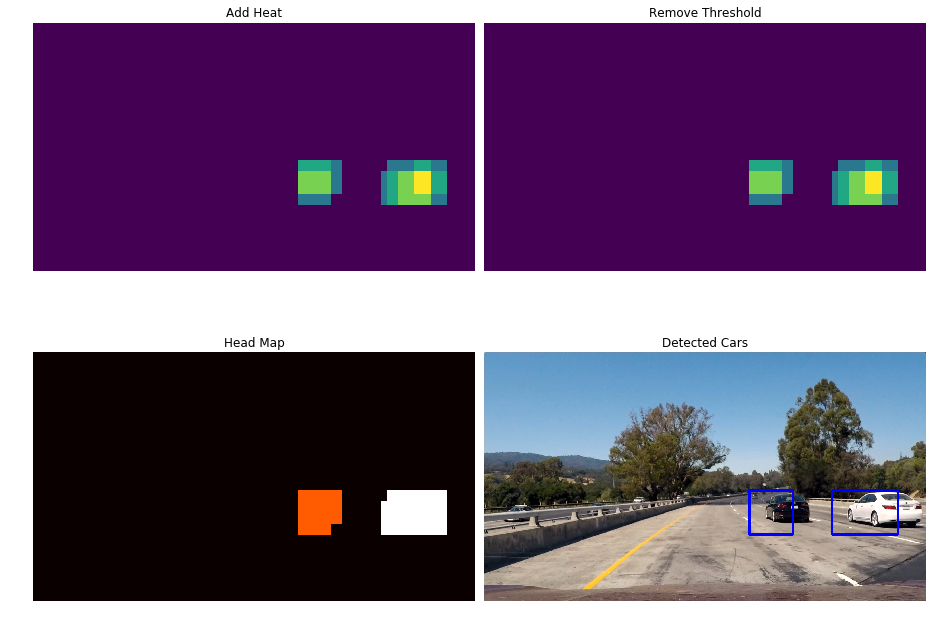

In [45]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    drawed_car_positions = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        drawed_car_positions.append((bbox[0], bbox[1]))
    # Return the image
    return img, drawed_car_positions

heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, car_positions)

###### Apply threshold to help remove false positives ############
heat_threshold = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat_threshold, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, _ = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize = (16, 12))
fig.subplots_adjust(hspace = 0.02, wspace = 0.02)
plt.subplot(221)
plt.imshow(heat)
plt.title('Add Heat')
plt.axis('off')
plt.subplot(222)
plt.imshow(heat_threshold)
plt.title('Remove Threshold')
plt.axis('off')
plt.subplot(223)
plt.imshow(labels[0], cmap='hot')
plt.title('Head Map')
plt.axis('off')
plt.subplot(224)
plt.imshow(draw_img)
plt.title('Detected Cars')
plt.axis('off')
plt.savefig("output_images/headmap_and_detected_cars.png") 
print('ok')

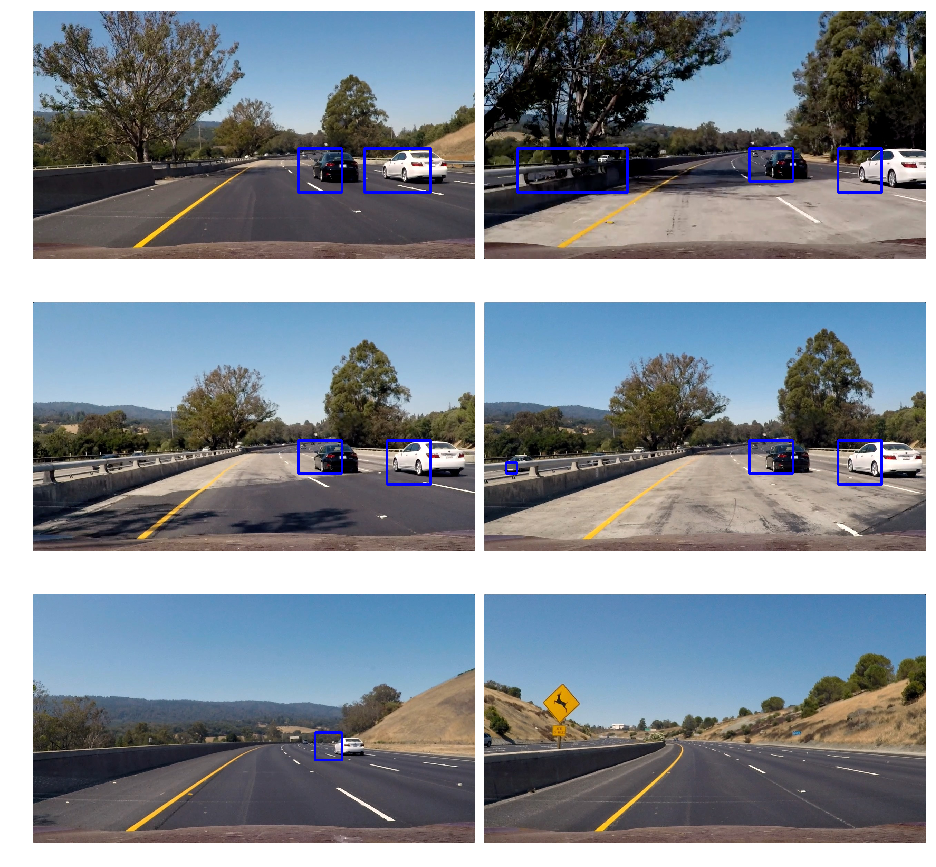

In [15]:
#Define a process function to use the find_car() function
def process_image_with_find_car(img):
    
    detected_cars = []
    # Scan different windows
    xstart = 65
    xstop = 1280
    ystart = 400
    ystop =  464
    scale =  1.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    ystart = 416
    ystop =  480
    scale =  1.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    ystart = 400
    ystop =  496
    scale =  1.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    
    ystart = 432
    ystop =  528
    scale =  1.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    
    ystart = 400
    ystop =  4528
    scale =  2.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    
    ystart = 432
    ystop =  560
    scale =  2.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    
    ystart = 400
    ystop =  596
    scale =  3.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    ystart = 464
    ystop =  660
    scale =  3.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    
    car_positions = [i for sl in detected_cars for i in sl]  
    heatmap_img = np.zeros_like(img[:, :, 0])
    heatmap_img = add_heat(heatmap_img, car_positions) 
    ############### Threshold set to 2 #################
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    labeled_img, drawed_car_positions = draw_labeled_bboxes(np.copy(img), labels)  
    return labeled_img

# Test find_cars with different zones and different window size (scale)

test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize = (16, 16))
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.02, wspace = 0.02)
for i, file in enumerate(test_images):
    axs[i].imshow(process_image_with_find_car(mpimg.imread(file)))
    axs[i].axis('off')
plt.savefig("output_images/process_the_test_images.png") 

In [16]:
from moviepy.editor import VideoFileClip
test_video_out = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image_with_find_car)
%time clip_test_out.write_videofile(test_video_out, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:10<00:00,  3.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 10.2 s, sys: 818 ms, total: 11 s
Wall time: 10.6 s


In [17]:
# Define a Vehicle() class to store the detected cars from previous frame
class Vehcile():
    def __init__(self, num_of_prevs = 10):
        self.prevs_car_positions = []
        self.num_of_prevs = num_of_prevs
    def add_detacted(self, cars):
        self.prevs_car_positions.append(cars)
        extra = len(self.prevs_car_positions) - self.num_of_prevs
        if extra > 0:
            self.prevs_car_positions = self.prevs_car_positions[extra:]
    

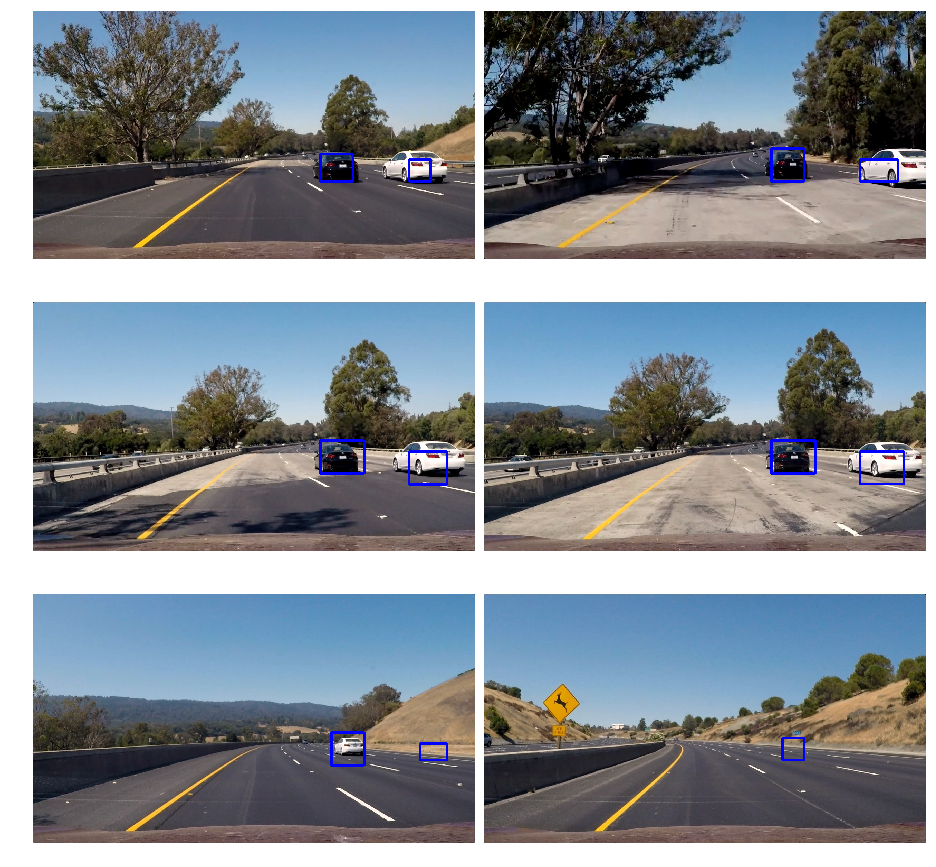

In [18]:
# Define the pipeline for the video processing

def pipeline(img):
    
    detected_cars = []
    # Scan different windows
    xstart = 0
    xstop = 1280 
    
    ystart = 368
    ystop =  464
    scale =  1.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    ystart = 416
    ystop =  480
    scale =  1.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    ystart = 400
    ystop =  496
    scale =  1.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    ystart = 432
    ystop =  528
    scale =  1.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    
    ystart = 400
    ystop =  452
    scale =  2.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    ystart = 432
    ystop =  560
    scale =  2.0
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )
    
    ystart = 400
    ystop =  596
    scale =  3.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    ystart = 464
    ystop =  660
    scale =  3.5
    detected_cars.append(find_cars(img, xstart, xstop, ystart, ystop, scale, colorspace, hog_channel, svc,  
                                   X_scaler, orient, pix_per_cell, cell_per_block)
                        )

    car_positions = [i for sl in detected_cars for i in sl]  
        
    heatmap_img = np.zeros_like(img[:, :, 0])

    # add current detected cars to the Vehcile object
    if len(car_positions) > 0:
        vehcile.add_detacted(car_positions)
        
    # retrieve the car position from history and add to heat  
    for cars in vehcile.prevs_car_positions:
        heatmap_img = add_heat(heatmap_img, cars)
    #apply threshold
    heatmap_img = apply_threshold(heatmap_img, 3 + len(vehcile.prevs_car_positions)//1)
    labels = label(heatmap_img)   
    labeled_img, drawed_car_positions = draw_labeled_bboxes(np.copy(img), labels)  
    # add current drawed cars to the Vehcile object
    if len(drawed_car_positions) > 0:
        vehcile.add_detacted(drawed_car_positions)    
    return labeled_img

# Test find_cars with different zones and different window size (scale)

test_images = glob.glob('./test_images/test*.jpg')
vehcile = Vehcile(5)
fig, axs = plt.subplots(3, 2, figsize = (16, 16))
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.02, wspace = 0.02)
for i, file in enumerate(test_images):
    axs[i].imshow(pipeline(mpimg.imread(file)))
    axs[i].axis('off')
plt.savefig("output_images/process_the_test_images_with_pipeline.png") 

In [21]:
vehcile = Vehcile(10)
project_video_out = 'project_video_out.mp4'
clip_project = VideoFileClip('project_video.mp4')#.subclip(10,20)
############ set the pipeline here ################
# process video
clip_project_out = clip_project.fl_image(pipeline)

%time clip_project_out.write_videofile(project_video_out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [05:23<00:00,  4.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 5min 26s, sys: 25 s, total: 5min 50s
Wall time: 5min 23s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_out = 'project_video_out.mp4'
))